In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt as sqrt
from numpy import pi as pi

# make qutip available in the rest of the notebook
from qutip import *

In [2]:
from scipy.constants import k, h, mu_0, e
from scipy.special import ellipk

phi_0 = h/2/e # For superconductor

pi = np.pi

In [3]:
from numpy.fft import rfft, ifft, fft, irfft
plt.style.use('genstyle')

In [4]:
1.78e-13*160e-9/phi_0

1.3772866722915694e-05

In [5]:
import os
os.getcwd()

'/Users/lulu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD thesis/Majorana Simulation'

# Josephson energy

In [6]:
def fourier_expansion(x, data, norm='forward', mode='zeroed', plot=True, res=1e-2):
    if mode=='zeroed':
        mean = np.mean(data)
    else:
        mean = 0
    X = fft(data - mean, norm=norm)
    freq = np.fft.fftfreq(len(x), d=(max(x)-min(x))/2/np.pi/len(x))
    
    if plot:
        
        fig, ax = plt.subplots()
        ax.plot(x/np.pi, data, 'b')
        ax.plot(x/np.pi, ifft(X, norm=norm)+mean, 'r*')
        ax.set_xlabel(r'$\phi$/$\pi$')
        ax.set_ylabel('FFT Amplitude |X(freq)|')        

        fig, ax = plt.subplots()
        ax.plot(freq, 2*np.abs(X), 'b*')
        minimum = 2*min(np.abs(X))
        maximum = 2*max(np.abs(X))
        ran = maximum - minimum
        ax.set_xlabel('Freq (Hz)')
        ax.set_ylabel('FFT Amplitude |X(freq)|')
        ax.set_xlim(xmin=-0.1, xmax=10)
        ax.set_ylim(ymin=minimum-0.1*ran, ymax=maximum+0.1*ran)
    
    #X = np.abs(X)
    X[abs(X)<res] = 0
    
    return freq, X

def find_Ej(freq, X, size=5):
    Ej = 0
    if size > len(X)//2+1:
        size = len(X)//2+1
    for i in range(size):
        Ej += 2*freq[i]**2*np.abs(X[i])
    return Ej

def basis_func(f, x, arr):
    #print(int(f))
    return (x+0j)*np.exp(1j*f*arr)


def SNS(phi, tau_list, sc_gap=1):
    Ejs = []
    for p in phi:
        Ej = np.sum(np.dot(sc_gap, np.sqrt(1-tau_list*np.sin(p/2)**2)))
        #print(Ej)
        Ejs.append(Ej)
    return np.array(Ejs)

def E_m(phi, Em=1):
    return -Em*np.cos(phi/2)

def SIS(phi, Ej=1):
    return Ej*np.cos(phi)

def SIS_squid(flux_n, d, Ej0=1):
    #return -Ej*np.cos(pi*flux_n)*np.sqrt(1+(d*np.tan(pi*flux_n))**2)
    return Ej0*np.sqrt(np.cos(pi*flux_n)**2 + d**2*np.sin(pi*flux_n)**2)

def SIS_squid_flux(flux_n, p, d=0, Ej0=1):
    Ej1 = Ej0/2*(1+d)
    Ej2 = Ej0/2*(1-d)
    return SIS(p, Ej=Ej1) + SIS(p-2*pi*flux_n, Ej=Ej2)

def SNS_squid_flux(flux_n, p, tau_list1, tau_list2, d=0, sc_gap=1):
    sc_gap2 = (1-d)/(1+d)*sc_gap
    return SNS(p, tau_list1, sc_gap=sc_gap) + SNS(p-2*pi*flux_n, tau_list2, sc_gap=sc_gap2)

# Qubit Model

In [7]:
N=15

def H_c(Ec, ng=0, N=15):
    return Qobj(np.diag(Ec * (np.arange(-N,N+1)-ng)**2))


def Ej_basis(i, N=15):
    if i==0:
        return 0.5*np.ones((2*N+1, 2*N+1))
    return np.diag(-np.ones(2*N+1-np.abs(i)), i) #+  np.diag(-np.ones(2*N+1-i), -i))

def H_J(freq, X, N=15, size=10):
    H_j = (0+0j)*np.ones((2*N+1, 2*N+1))
    for i in range(size):
        H_j += X[i]*Ej_basis(i, N=N)
        if i!=0:
            H_j += X[-i]*Ej_basis(-i, N=N)
    return Qobj(H_j)

def H_J_SIS(Ej, N=15):
    return - Qobj(0.5 * Ej * (np.diag(np.ones(2*N-1), 2) + np.diag(np.ones(2*N-1), -2)))

def H_M(Em, N=15):
    return - Qobj(0.5 * Em * (np.diag(np.ones(2*N), 1) + np.diag(np.ones(2*N), -1)))

def E_j(Ej0, flux_n, d=0, phase_shift=0):
    phase = flux_n*np.pi + phase_shift
    return Ej0*np.sqrt(np.cos(phase)**2+d**2*np.sin(phase)**2)

def H_J_SIS_SQUID(flux_n, Ej_max, d=0, phase_shift=0, N=15):
    return H_J_SIS(E_j(Ej_max, flux_n, d=d, phase_shift=phase_shift), N=N)


def fq(H):
    energies = H.eigenenergies()
    return np.abs(energies[2]-energies[0])

def f_c_I(flux_n, fc, fqs, Ej0,d):
    return (fc+fqs)/2-sqrt(g(flux_n,fc,Ej0,d)**2+(fqs-fc)**2/4)

def g(flux_n, fc, Ej0, d):
    return g0*fc*np.power(Ej0, 1/4)*np.power(cos(np.pi*flux_n)**2+d**2*sin(np.pi*flux_n)**2, 1/8)

def f_q_ana(flux_n, Ej, d, n_shift=0, N=15):
    fq_ana = []
    for n in flux_n:
        H_J_ana = H_J_SIS_SQUID(n, Ej, d=d, N=N)
        H_ana = H_J_ana + H_c(Ec, N=N)
        fq_ana.append(fq(H_ana))
    return np.array(fq_ana)

def f_c_ana(flux_n, fc, Ej0, d, n_shift=0, N=15):
    return f_c_I(flux_n, fc, f_q_ana(flux_n, Ej0, d, n_shift=n_shift, N=N), Ej0, d)

def plot_spectrum(x_var, spectrums, cutoff=2):
    transitions = []
#    for s in spectrums:
#        print(s-ref)
#        transitions.append(s-ref)
#        ref = s
    transitions = np.array(spectrums).T
    plot_data = transitions[0:cutoff]
    ref = transitions[0]
    for d in plot_data:
        plt.plot(x_var, d-ref)
    return plot_data

# SIS Transmon

## Without Majorana

In [ ]:
#Ec = 10e9
Ec = 230e6
Ej = 100e9
N=10
size = 11
sc_gap = 73.5e9
tau_list = 0.8*np.ones(4)
phase = np.linspace(0, 4*pi, 401)


ng = np.linspace(-2,2,201)
fqs = []
spectrums = []

fig, ax = plt.subplots()

for n in ng:
    data = SIS(phase, Ej=Ej) + SNS(phase, tau_list=tau_list, sc_gap=sc_gap)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    Ej_eff = find_Ej(freq, X, size=size)
    #H = H_c(Ec, ng=n) + H_J(X, size=size, N=N)
    fqs.append(fq(H))
    spectrums.append(H.eigenenergies())
    if n==0:
        ax.plot(phase/pi, data-min(data), 'k')
        #ax.plot(phase/pi, SIS(phase, Ej=Ej_eff))
#plt.plot(ng, fqs)


fig.savefig('SIS_SNS_potential.pdf')
#spectrums = np.array(spectrums).T
#plt.plot(ng, spectrums)
#plot_spectrum(ng, spectrums,cutoff=4)

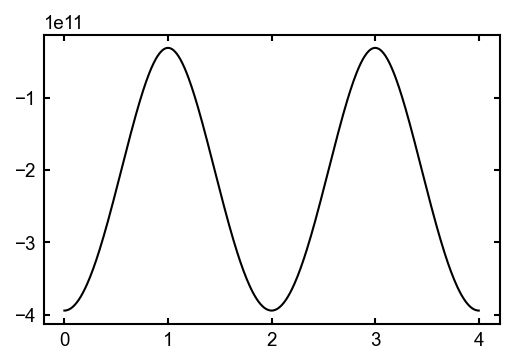

In [6]:
#Ec = 10e9
Ec = 230e6
Ej = 100e9
N=10
size = 11
sc_gap = 73.5e9
tau_list = 0.8*np.ones(4)
phase = np.linspace(0, 4*pi, 401)


ng = np.linspace(-2,2,201)
fqs = []
spectrums = []

fig, ax = plt.subplots()

for n in ng:
    data = SIS(phase, Ej=Ej) + SNS(phase, tau_list=tau_list, sc_gap=sc_gap)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    Ej_eff = find_Ej(freq, X, size=size)
    H = H_c(Ec, ng=n) + H_J(X, size=size, N=N)
    fqs.append(fq(H))
    spectrums.append(H.eigenenergies())
    if n==0:
        ax.plot(phase/pi, data-min(data), 'k')
        #ax.plot(phase/pi, SIS(phase, Ej=Ej_eff))
#plt.plot(ng, fqs)


fig.savefig('SIS_SNS_potential.pdf')
#spectrums = np.array(spectrums).T
#plt.plot(ng, spectrums)
#plot_spectrum(ng, spectrums,cutoff=4)

## With Majorana

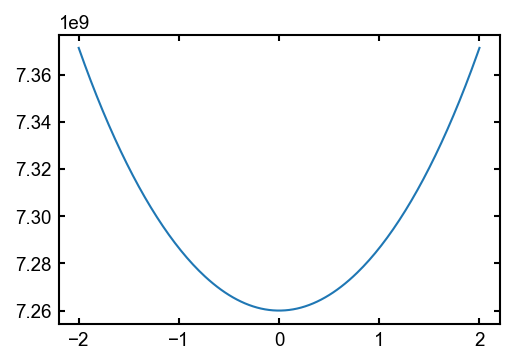

In [15]:
#Ec = 10e9
Ec = 230e6
Ej = 30e9
Em = 50e6

ng = np.linspace(-2,2,201)
fqs = []
spectrums = []
for n in ng:
    H = H_c(Ec, ng=n) + H_J_SIS(Ej) + H_M(Em)
    fqs.append(fq(H))
    spectrums.append(H.eigenenergies())
#plot_spectrum(ng, spectrums,cutoff=4)
plt.plot(ng, fqs)

# With field dependent gap

In [60]:
2*1.3%1

0.6000000000000001

In [8]:
import math

phi_0 = h/2/e # For superconductor

def gap_suppression(r, delta, Bc):
    return delta*np.power((1 - (r/Bc)**2), 1/2)

def fraunhofer(B, A, I):
    phi = B*A/phi_0
    val = I*np.abs(np.sin(pi*phi)/(pi*phi))
    if math.isnan(val):
        return I
    else:
        return val

def long_fraunhofer(B, A, I):
    # B: applied field
    # A: effective cross-sectional area
    # C: prefactor--Ej = hbarIc/e
    phi = B*A/phi_0
    n = phi*pi/np.sqrt(3)
    val = I*np.abs(n/np.sinh(n))
    if math.isnan(val):
        return I
    else:
        return val

def long_ballistic_fraunhofer(B, A, I):
    phi = B*A/phi_0
    val = I*(1-B*A/phi_0%1)*(B*A/phi_0%1)/np.abs(B*A/phi_0)
    if math.isnan(val):
        return I
    else:
        return val

def SIS_squid(flux_n, d=0, Ej0=1):
    #return -Ej*np.cos(pi*flux_n)*np.sqrt(1+(d*np.tan(pi*flux_n))**2)
    return Ej0*np.sqrt(np.cos(pi*flux_n)**2 + d**2*np.sin(pi*flux_n)**2)

def squid(B, A, I, d=0):
    flux_n = B*A/phi_0
    return SIS_squid(flux_n, d=d, Ej0=I)

In [9]:
phi_0/(110*20*1e-18)

0.9399244765736042

In [72]:
0.1*A_x/phi_0

0.08704761271505705

In [32]:
fields = fields[fields!=0.5]

In [21]:
h/2/e/(1000e-18)

2.0678338484619294

## Modified Figures for PhD Thesis

### Ballistic

In [16]:
phi_0/A_y

0.9399244765736042

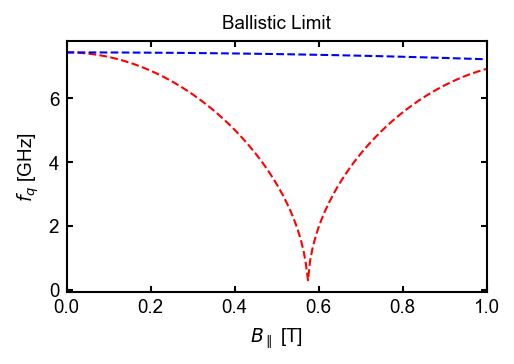

In [29]:
fig, ax = plt.subplots()

N=10
size = 10

fields = np.linspace(0, 1, 201) # in units of Tesla
Bc = 3 # in units of Tesla
ng=0.25

A_y = 110*20*1e-18
A_x = 90*20*1e-18

sc_gap = 0e9
n_bal = 1
tau_list = 0.9*np.ones(n_bal)
phase = np.linspace(0, 4*pi, 401)
Ec = 230e6
Ej0 = 30e9
Em = 100e6
fqs_y = []
fqs_x = []
Ej_SNS_eff = []


for B in fields:
    Ej = gap_suppression(B, Ej0, Bc)
    Ej_x = squid(B, A_x, Ej)
    fqs_y.append(np.sqrt(8*Ec*Ej))
    fqs_x.append(np.sqrt(8*Ec*Ej_x))
    ## y direction


fqs_x = np.array(fqs_x)
fqs_y = np.array(fqs_y)


ax.plot(fields, fqs_x*1e-9, 'r--', label=r'$B_x$')
ax.plot(fields, fqs_y*1e-9, 'b--', label=r'$B_y$')
ax.set_ylabel(r'$f_q$ [GHz]')
ax.set_xlim(xmin=0, xmax=1)
ax.set_xlabel(r'$B_\parallel$ [T]')
#ax.legend()
ax.set_title('Ballistic Limit')
fig.savefig('field_depend_ballistic.pdf')

#from matplotlib.lines import Line2D
#from matplotlib.patches import Patch
#
#legend_elements = [Line2D([0], [0], color='k', ls='-', label='Long limit'),
#                   Line2D([0], [0], color='k', ls='--', label='Short limit'),
#                   Patch(facecolor='b', edgecolor='b',
#                         label=r'$B_y$'),
#                   Patch(facecolor='r', edgecolor='r',
#                         label=r'$B_x$')]


### Diffusive limit

/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_44440/2490405250.py:10: RuntimeWarning: invalid value encountered in double_scalars
  val = I*np.abs(np.sin(pi*phi)/(pi*phi))
/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_44440/2490405250.py:22: RuntimeWarning: invalid value encountered in double_scalars
  val = I*np.abs(n/np.sinh(n))


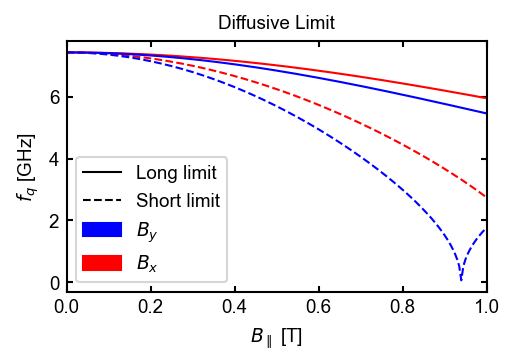

In [30]:
fig, ax = plt.subplots()

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], color='k', ls='-', label='Long limit'),
                   Line2D([0], [0], color='k', ls='--', label='Short limit'),
                   Patch(facecolor='b', edgecolor='b',
                         label=r'$B_y$'),
                   Patch(facecolor='r', edgecolor='r',
                         label=r'$B_x$')]


N=10
size = 10

fields = np.linspace(0, 1, 201) # in units of Tesla
Bc = 3 # in units of Tesla
ng=0.25

A_y = 110*20*1e-18
A_x = 90*20*1e-18

sc_gap = 0e9
n_bal = 1
tau_list = 0.9*np.ones(n_bal)
phase = np.linspace(0, 4*pi, 401)
Ec = 230e6
Ej0 = 30e9
Em = 100e6
fqs_y = []
fqs_x = []
fqs_y_long = []
fqs_x_long = []


for B in fields:
    Ej = gap_suppression(B, Ej0, Bc)
    Ej_x = fraunhofer(B, A_x, Ej)
    Ej_y = fraunhofer(B, A_y, Ej)
    Ej_x_long = long_fraunhofer(B, A_x, Ej)
    Ej_y_long = long_fraunhofer(B, A_y, Ej)
    fqs_y.append(np.sqrt(8*Ec*Ej_y))
    fqs_x.append(np.sqrt(8*Ec*Ej_x))
    
    fqs_y_long.append(np.sqrt(8*Ec*Ej_y_long))
    fqs_x_long.append(np.sqrt(8*Ec*Ej_x_long))
    ## y direction


fqs_x = np.array(fqs_x)
fqs_y = np.array(fqs_y)
fqs_x_long = np.array(fqs_x_long)
fqs_y_long = np.array(fqs_y_long)


ax.plot(fields, fqs_x*1e-9, 'r--', label=r'$B_x$')
ax.plot(fields, fqs_y*1e-9, 'b--', label=r'$B_y$')
ax.plot(fields, fqs_x_long*1e-9, 'r', label=r'$B_x$')
ax.plot(fields, fqs_y_long*1e-9, 'b', label=r'$B_y$')
ax.set_ylabel(r'$f_q$ [GHz]')
ax.set_xlim(xmin=0, xmax=1)
ax.set_xlabel(r'$B_\parallel$ [T]')
ax.legend(handles=legend_elements)
ax.set_title('Diffusive Limit')
fig.savefig('field_depend_diffusive.pdf')



In [ ]:
## SIS: analytic form
## SNS: numeric form
## MBS: one SNS channel turns into MBS

# Ballistic limit

fig, axes = plt.subplots(3,1, sharex=True, figsize=(3.25, 5.3))

N=10
size = 10

fields = np.linspace(0, 1, 101) # in units of Tesla
Bc = 3 # in units of Tesla
ng=0.25

A_y = 110*20*1e-18
A_x = 90*20*1e-18

sc_gap = 0e9
n_bal = 1
tau_list = 0.9*np.ones(n_bal)
phase = np.linspace(0, 4*pi, 401)
Ec = 230e6
Ej0 = 30e9
Em = 100e6
fqs_y = []
fqs_long_y = []
fqs_x = []
fqs_long_x = []
Ej_SNS_eff = []

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], color='k', ls='-', label='Long limit'),
                   Line2D([0], [0], color='k', ls='--', label='Short limit'),
                   Patch(facecolor='b', edgecolor='b',
                         label=r'$B_y$'),
                   Patch(facecolor='r', edgecolor='r',
                         label=r'$B_x$')]



for B in fields:
    Ej_y = gap_suppression(B, Ej0, Bc)
    sc_y = gap_suppression(B, sc_gap, Bc)
    Ej_long_y = long_fraunhofer(B, A_y, Ej_y)
    Ej_x = fraunhofer(B, A_x, Ej_y)
    Ej_long_x = long_fraunhofer(B, A_x, Ej_y)
    sc_x = fraunhofer(B, A_x, sc_y)
    sc_x_long = long_ballistic_fraunhofer(B, A_x, sc_y)
    ## y direction

        
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_y)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    Ej_SNS_eff.append(find_Ej(freq, X, size=size))
    H_y = H_c(Ec, ng=n) + H_J_SIS(Ej_y) + H_J(X, size=size, N=N)
    H_y_long = H_c(Ec, ng=n) + H_J_SIS(Ej_long_y) + H_J(X, size=size, N=N)
    fqs_y.append(fq(H_y))
    fqs_long_y.append(fq(H_y_long))

    ## x direction ballistic
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    H_x = H_c(Ec, ng=n) + H_J_SIS(Ej_x) + H_J(X, size=size, N=N)
    fqs_x.append(fq(H_x))

    ## x direction long
    #print(sc_x_long)
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x_long)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    H_x_long = H_c(Ec, ng=n) + H_J(X, size=size, N=N) + H_J_SIS(Ej_long_x)
    fqs_long_x.append(fq(H_x_long))    

fqs_x = np.array(fqs_x)
fqs_long_x = np.array(fqs_long_x)
fqs_y = np.array(fqs_y)
fqs_long_y = np.array(fqs_long_y)


axes[0].plot(fields, fqs_x*1e-9, 'r--', label='short')
axes[0].plot(fields, fqs_long_x*1e-9, 'r-', label='long')
axes[0].plot(fields, fqs_y*1e-9, 'b--', label='short')
axes[0].plot(fields, fqs_long_y*1e-9, 'b-', label='long')


axes[0].set_ylabel(r'$f_q$ [GHz]')
axes[0].set_xlim(xmin=0, xmax=1)


#axins.set_ylim(ymin=7, ymax=7.25)

print(Ej_SNS_eff[0]/Ej0)
axes[0].set_title('r = 0')

sc_gap = 2e9
Ej_SNS_eff = []
fqs_y = []
fqs_long_y = []
fqs_x = []
fqs_long_x = []
Ej_SNS_eff = []

for B in fields:
    Ej_y = gap_suppression(B, Ej0, Bc)
    sc_y = gap_suppression(B, sc_gap, Bc)
    Ej_long_y = long_fraunhofer(B, A_y, Ej_y)
    Ej_x = fraunhofer(B, A_x, Ej_y)
    Ej_long_x = long_fraunhofer(B, A_x, Ej_y)
    sc_x = fraunhofer(B, A_x, sc_y)
    sc_x_long = long_ballistic_fraunhofer(B, A_x, sc_y)
    ## y direction
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_y)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    Ej_SNS_eff.append(find_Ej(freq, X, size=size))
    H_y = H_c(Ec, ng=n) + H_J_SIS(Ej_y) + H_J(X, size=size, N=N)
    H_y_long = H_c(Ec, ng=n) + H_J_SIS(Ej_long_y) + H_J(X, size=size, N=N)
    if np.abs(B*A_y/phi_0 - 0.5) < 0.1:
        B_m = B
        H = H_c(Ec) + H_J_SIS(Ej_y) + H_M(Em) + H_J(X, size=size, N=N)
        energies = H.eigenenergies()
        fq_transmon = energies[2] - energies[1]
        fq_transmon2 = energies[3] - energies[0]
        fq_normal = energies[2]-energies[0]
    fqs_y.append(fq(H_y))
    fqs_long_y.append(fq(H_y_long))

    ## x direction ballistic
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    H_x = H_c(Ec, ng=n) + H_J_SIS(Ej_x) + H_J(X, size=size, N=N)
    fqs_x.append(fq(H_x))

    ## x direction long
    #print(sc_x_long)
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x_long)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    H_x_long = H_c(Ec, ng=n) + H_J(X, size=size, N=N) + H_J_SIS(Ej_long_x)
    fqs_long_x.append(fq(H_x_long))    

fqs_x = np.array(fqs_x)
fqs_long_x = np.array(fqs_long_x)
fqs_y = np.array(fqs_y)
fqs_long_y = np.array(fqs_long_y)



axes[1].plot(fields, fqs_x*1e-9, 'r--', label='short')
axes[1].plot(fields, fqs_long_x*1e-9, 'r-', label='long')
axes[1].plot(fields, fqs_y*1e-9, 'b--', label='short')
axes[1].plot(fields, fqs_long_y*1e-9, 'b-', label='long')

#axins_1.set_ylim(ymin=7, ymax=7.25)
#ax.set_xlabel(r'B [T]')
axes[1].set_ylabel(r'$f_q$ [GHz]')
axes[1].set_xlim(xmin=0, xmax=1)
#ax.legend()

axins = axes[1].inset_axes([0.15,0.15,0.4,0.4])
axins.plot(fields, fqs_y*1e-9, '--', c='b')
axins.plot(B_m, fq_normal*1e-9, 'C4.', ms=5)
axins.plot(B_m, fq_transmon*1e-9, 'C4.', ms=5)
axins.plot(B_m, fq_transmon2*1e-9, 'C4.', ms=5)
axins.set_xlim(xmin=0.45, xmax=0.65)

print(Ej_SNS_eff[0]/Ej0)
axes[1].set_title('r = {:.2f}'.format(Ej_SNS_eff[0]/Ej0))


sc_gap = 8e9
Ej_SNS_eff = []
fqs_y = []
fqs_long_y = []
fqs_x = []
fqs_long_x = []
Ej_SNS_eff = []

for B in fields:
    Ej_y = gap_suppression(B, Ej0, Bc)
    sc_y = gap_suppression(B, sc_gap, Bc)
    Ej_long_y = long_fraunhofer(B, A_y, Ej_y)
    Ej_x = fraunhofer(B, A_x, Ej_y)
    Ej_long_x = long_fraunhofer(B, A_x, Ej_y)
    sc_x = fraunhofer(B, A_x, sc_y)
    sc_x_long = long_ballistic_fraunhofer(B, A_x, sc_y)

    ## y direction
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_y)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    Ej_SNS_eff.append(find_Ej(freq, X, size=size))
    H_y = H_c(Ec, ng=n) + H_J_SIS(Ej_y) + H_J(X, size=size, N=N)
    H_y_long = H_c(Ec, ng=n) + H_J_SIS(Ej_long_y) + H_J(X, size=size, N=N)
    fqs_y.append(fq(H_y))
    fqs_long_y.append(fq(H_y_long))


    ## x direction ballistic
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    H_x = H_c(Ec, ng=n) + H_J_SIS(Ej_x) + H_J(X, size=size, N=N)
    fqs_x.append(fq(H_x))

    ## x direction long
    #print(sc_x_long)
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x_long)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    H_x_long = H_c(Ec, ng=n) + H_J(X, size=size, N=N) + H_J_SIS(Ej_long_x)
    fqs_long_x.append(fq(H_x_long))    

fqs_x = np.array(fqs_x)
fqs_long_x = np.array(fqs_long_x)
fqs_y = np.array(fqs_y)
fqs_long_y = np.array(fqs_long_y)

axes[2].plot(fields, fqs_x*1e-9, 'r--', label='short')
axes[2].plot(fields, fqs_long_x*1e-9, 'r-', label='long')
axes[2].plot(fields, fqs_y*1e-9, 'b--', label='short')
axes[2].plot(fields, fqs_long_y*1e-9, 'b-', label='long')

#axins_1.set_ylim(ymin=7, ymax=7.25)
axes[2].set_xlabel(r'B [T]')
axes[2].set_ylabel(r'$f_q$ [GHz]')
axes[2].set_xlim(xmin=0, xmax=1)
axes[2].legend(handles=legend_elements)
#ax.legend()


print(Ej_SNS_eff[0]/Ej0)
axes[2].set_title('r = {:.2f}'.format(Ej_SNS_eff[0]/Ej0))

fig.savefig('fqVSfields_v2.pdf')

## Geometric Surface Area

/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_5181/2935501408.py:22: RuntimeWarning: invalid value encountered in double_scalars
  val = I*np.abs(n/np.sinh(n))
/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_5181/2935501408.py:10: RuntimeWarning: invalid value encountered in double_scalars
  val = I*np.abs(np.sin(pi*phi)/(pi*phi))
/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_5181/2935501408.py:30: RuntimeWarning: invalid value encountered in double_scalars
  val = I*(1-B*A/phi_0%1)*(B*A/phi_0%1)/np.abs(B*A/phi_0)


TypeError: H_J() missing 1 required positional argument: 'X'

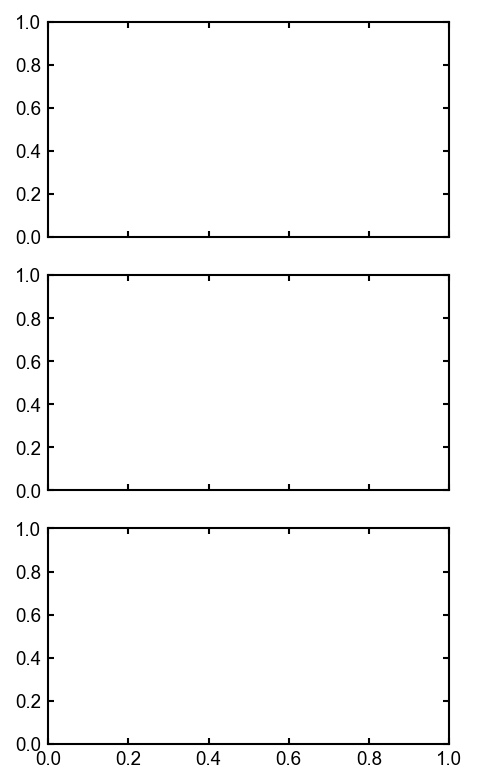

In [24]:
## SIS: analytic form
## SNS: numeric form
## MBS: one SNS channel turns into MBS

# Ballistic limit

fig, axes = plt.subplots(3,1, sharex=True, figsize=(3.25, 5.3))

N=10
size = 10

fields = np.linspace(0, 1, 101) # in units of Tesla
Bc = 3 # in units of Tesla
ng=0.25

A_y = 110*20*1e-18
A_x = 90*20*1e-18

sc_gap = 0e9
n_bal = 1
tau_list = 0.9*np.ones(n_bal)
phase = np.linspace(0, 4*pi, 401)
Ec = 230e6
Ej0 = 30e9
Em = 100e6
fqs_y = []
fqs_long_y = []
fqs_x = []
fqs_long_x = []
Ej_SNS_eff = []

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], color='k', ls='-', label='Long limit'),
                   Line2D([0], [0], color='k', ls='--', label='Short limit'),
                   Patch(facecolor='b', edgecolor='b',
                         label=r'$B_y$'),
                   Patch(facecolor='r', edgecolor='r',
                         label=r'$B_x$')]



for B in fields:
    Ej_y = gap_suppression(B, Ej0, Bc)
    sc_y = gap_suppression(B, sc_gap, Bc)
    Ej_long_y = long_fraunhofer(B, A_y, Ej_y)
    Ej_x = fraunhofer(B, A_x, Ej_y)
    Ej_long_x = long_fraunhofer(B, A_x, Ej_y)
    sc_x = fraunhofer(B, A_x, sc_y)
    sc_x_long = long_ballistic_fraunhofer(B, A_x, sc_y)
    ## y direction

        
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_y)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    Ej_SNS_eff.append(find_Ej(freq, X, size=size))
    H_y = H_c(Ec, ng=n) + H_J_SIS(Ej_y) + H_J(X, size=size, N=N)
    H_y_long = H_c(Ec, ng=n) + H_J_SIS(Ej_long_y) + H_J(X, size=size, N=N)
    fqs_y.append(fq(H_y))
    fqs_long_y.append(fq(H_y_long))

    ## x direction ballistic
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    H_x = H_c(Ec, ng=n) + H_J_SIS(Ej_x) + H_J(X, size=size, N=N)
    fqs_x.append(fq(H_x))

    ## x direction long
    #print(sc_x_long)
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x_long)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    H_x_long = H_c(Ec, ng=n) + H_J(X, size=size, N=N) + H_J_SIS(Ej_long_x)
    fqs_long_x.append(fq(H_x_long))    

fqs_x = np.array(fqs_x)
fqs_long_x = np.array(fqs_long_x)
fqs_y = np.array(fqs_y)
fqs_long_y = np.array(fqs_long_y)


axes[0].plot(fields, fqs_x*1e-9, 'r--', label='short')
axes[0].plot(fields, fqs_long_x*1e-9, 'r-', label='long')
axes[0].plot(fields, fqs_y*1e-9, 'b--', label='short')
axes[0].plot(fields, fqs_long_y*1e-9, 'b-', label='long')


axes[0].set_ylabel(r'$f_q$ [GHz]')
axes[0].set_xlim(xmin=0, xmax=1)


#axins.set_ylim(ymin=7, ymax=7.25)

print(Ej_SNS_eff[0]/Ej0)
axes[0].set_title('r = 0')

sc_gap = 2e9
Ej_SNS_eff = []
fqs_y = []
fqs_long_y = []
fqs_x = []
fqs_long_x = []
Ej_SNS_eff = []

for B in fields:
    Ej_y = gap_suppression(B, Ej0, Bc)
    sc_y = gap_suppression(B, sc_gap, Bc)
    Ej_long_y = long_fraunhofer(B, A_y, Ej_y)
    Ej_x = fraunhofer(B, A_x, Ej_y)
    Ej_long_x = long_fraunhofer(B, A_x, Ej_y)
    sc_x = fraunhofer(B, A_x, sc_y)
    sc_x_long = long_ballistic_fraunhofer(B, A_x, sc_y)
    ## y direction
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_y)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    Ej_SNS_eff.append(find_Ej(freq, X, size=size))
    H_y = H_c(Ec, ng=n) + H_J_SIS(Ej_y) + H_J(X, size=size, N=N)
    H_y_long = H_c(Ec, ng=n) + H_J_SIS(Ej_long_y) + H_J(X, size=size, N=N)
    if np.abs(B*A_y/phi_0 - 0.5) < 0.1:
        B_m = B
        H = H_c(Ec) + H_J_SIS(Ej_y) + H_M(Em) + H_J(X, size=size, N=N)
        energies = H.eigenenergies()
        fq_transmon = energies[2] - energies[1]
        fq_transmon2 = energies[3] - energies[0]
        fq_normal = energies[2]-energies[0]
    fqs_y.append(fq(H_y))
    fqs_long_y.append(fq(H_y_long))

    ## x direction ballistic
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    H_x = H_c(Ec, ng=n) + H_J_SIS(Ej_x) + H_J(X, size=size, N=N)
    fqs_x.append(fq(H_x))

    ## x direction long
    #print(sc_x_long)
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x_long)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    H_x_long = H_c(Ec, ng=n) + H_J(X, size=size, N=N) + H_J_SIS(Ej_long_x)
    fqs_long_x.append(fq(H_x_long))    

fqs_x = np.array(fqs_x)
fqs_long_x = np.array(fqs_long_x)
fqs_y = np.array(fqs_y)
fqs_long_y = np.array(fqs_long_y)



axes[1].plot(fields, fqs_x*1e-9, 'r--', label='short')
axes[1].plot(fields, fqs_long_x*1e-9, 'r-', label='long')
axes[1].plot(fields, fqs_y*1e-9, 'b--', label='short')
axes[1].plot(fields, fqs_long_y*1e-9, 'b-', label='long')

#axins_1.set_ylim(ymin=7, ymax=7.25)
#ax.set_xlabel(r'B [T]')
axes[1].set_ylabel(r'$f_q$ [GHz]')
axes[1].set_xlim(xmin=0, xmax=1)
#ax.legend()

axins = axes[1].inset_axes([0.15,0.15,0.4,0.4])
axins.plot(fields, fqs_y*1e-9, '--', c='b')
axins.plot(B_m, fq_normal*1e-9, 'C4.', ms=5)
axins.plot(B_m, fq_transmon*1e-9, 'C4.', ms=5)
axins.plot(B_m, fq_transmon2*1e-9, 'C4.', ms=5)
axins.set_xlim(xmin=0.45, xmax=0.65)

print(Ej_SNS_eff[0]/Ej0)
axes[1].set_title('r = {:.2f}'.format(Ej_SNS_eff[0]/Ej0))


sc_gap = 8e9
Ej_SNS_eff = []
fqs_y = []
fqs_long_y = []
fqs_x = []
fqs_long_x = []
Ej_SNS_eff = []

for B in fields:
    Ej_y = gap_suppression(B, Ej0, Bc)
    sc_y = gap_suppression(B, sc_gap, Bc)
    Ej_long_y = long_fraunhofer(B, A_y, Ej_y)
    Ej_x = fraunhofer(B, A_x, Ej_y)
    Ej_long_x = long_fraunhofer(B, A_x, Ej_y)
    sc_x = fraunhofer(B, A_x, sc_y)
    sc_x_long = long_ballistic_fraunhofer(B, A_x, sc_y)

    ## y direction
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_y)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    Ej_SNS_eff.append(find_Ej(freq, X, size=size))
    H_y = H_c(Ec, ng=n) + H_J_SIS(Ej_y) + H_J(X, size=size, N=N)
    H_y_long = H_c(Ec, ng=n) + H_J_SIS(Ej_long_y) + H_J(X, size=size, N=N)
    fqs_y.append(fq(H_y))
    fqs_long_y.append(fq(H_y_long))


    ## x direction ballistic
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    H_x = H_c(Ec, ng=n) + H_J_SIS(Ej_x) + H_J(X, size=size, N=N)
    fqs_x.append(fq(H_x))

    ## x direction long
    #print(sc_x_long)
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x_long)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
    H_x_long = H_c(Ec, ng=n) + H_J(X, size=size, N=N) + H_J_SIS(Ej_long_x)
    fqs_long_x.append(fq(H_x_long))    

fqs_x = np.array(fqs_x)
fqs_long_x = np.array(fqs_long_x)
fqs_y = np.array(fqs_y)
fqs_long_y = np.array(fqs_long_y)

axes[2].plot(fields, fqs_x*1e-9, 'r--', label='short')
axes[2].plot(fields, fqs_long_x*1e-9, 'r-', label='long')
axes[2].plot(fields, fqs_y*1e-9, 'b--', label='short')
axes[2].plot(fields, fqs_long_y*1e-9, 'b-', label='long')

#axins_1.set_ylim(ymin=7, ymax=7.25)
axes[2].set_xlabel(r'B [T]')
axes[2].set_ylabel(r'$f_q$ [GHz]')
axes[2].set_xlim(xmin=0, xmax=1)
axes[2].legend(handles=legend_elements)
#ax.legend()


print(Ej_SNS_eff[0]/Ej0)
axes[2].set_title('r = {:.2f}'.format(Ej_SNS_eff[0]/Ej0))

fig.savefig('fqVSfields_v2.pdf')

## Fitted surface area

/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_5181/2935501408.py:22: RuntimeWarning: invalid value encountered in double_scalars
  val = I*np.abs(n/np.sinh(n))
/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_5181/2935501408.py:10: RuntimeWarning: invalid value encountered in double_scalars
  val = I*np.abs(np.sin(pi*phi)/(pi*phi))
/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_5181/2935501408.py:30: RuntimeWarning: invalid value encountered in double_scalars
  val = I*(1-B*A/phi_0%1)*(B*A/phi_0%1)/np.abs(B*A/phi_0)


0.0


/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_5181/2935501408.py:22: RuntimeWarning: invalid value encountered in double_scalars
  val = I*np.abs(n/np.sinh(n))
/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_5181/2935501408.py:10: RuntimeWarning: invalid value encountered in double_scalars
  val = I*np.abs(np.sin(pi*phi)/(pi*phi))
/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_5181/2935501408.py:30: RuntimeWarning: invalid value encountered in double_scalars
  val = I*(1-B*A/phi_0%1)*(B*A/phi_0%1)/np.abs(B*A/phi_0)
/Users/lulu/anaconda3/envs/phd/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_5181/2935501408.py:22: RuntimeWarning: invalid value encountered in double_scalars
  val = I*np.abs(n/np.sinh(n))
/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_5181/2935501

0.16309149297317724
0.4744787184383623


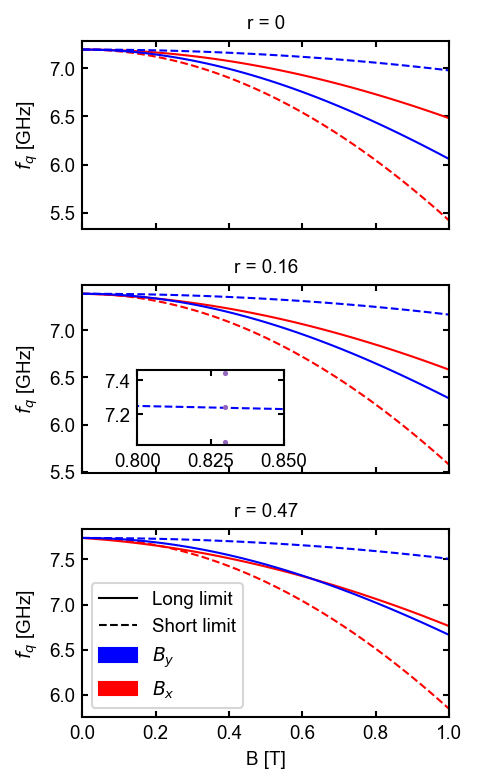

In [30]:
## SIS: analytic form
## SNS: numeric form
## MBS: one SNS channel turns into MBS

# Ballistic limit

fig, axes = plt.subplots(3,1, sharex=True, figsize=(3.25, 5.3))

N=15
size = 15

fields = np.linspace(0, 1, 101) # in units of Tesla
Bc = 3 # in units of Tesla
ng=0.25

A_y = 1.49431892e-15
A_x = 1.06674797e-15

sc_gap = 0e9
n_bal = 1
tau_list = 0.9*np.ones(n_bal)
phase = np.linspace(0, 4*pi, 401)
Ec = 230e6
Ej0 = 30e9
Em = 100e6
fqs_y = []
fqs_long_y = []
fqs_x = []
fqs_long_x = []
Ej_SNS_eff = []
res = 1e6

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], color='k', ls='-', label='Long limit'),
                   Line2D([0], [0], color='k', ls='--', label='Short limit'),
                   Patch(facecolor='b', edgecolor='b',
                         label=r'$B_y$'),
                   Patch(facecolor='r', edgecolor='r',
                         label=r'$B_x$')]



for B in fields:
    Ej_y = gap_suppression(B, Ej0, Bc)
    sc_y = gap_suppression(B, sc_gap, Bc)
    Ej_long_y = long_fraunhofer(B, A_y, Ej_y)
    Ej_x = fraunhofer(B, A_x, Ej_y)
    Ej_long_x = long_fraunhofer(B, A_x, Ej_y)
    sc_x = fraunhofer(B, A_x, sc_y)
    sc_x_long = long_ballistic_fraunhofer(B, A_x, sc_y)
    ## y direction

        
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_y)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=res)
    Ej_SNS_eff.append(find_Ej(freq, X, size=size))
    H_y = H_c(Ec, ng=ng) + H_J_SIS(Ej_y) + H_J(freq, X, size=size, N=N)
    H_y_long = H_c(Ec, ng=ng) + H_J_SIS(Ej_long_y) + H_J(freq, X, size=size, N=N)
    fqs_y.append(fq(H_y))
    fqs_long_y.append(fq(H_y_long))

    ## x direction ballistic
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=res)
    H_x = H_c(Ec, ng=ng) + H_J_SIS(Ej_x) + H_J(freq, X, size=size, N=N)
    fqs_x.append(fq(H_x))

    ## x direction long
    #print(sc_x_long)
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x_long)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=res)
    H_x_long = H_c(Ec, ng=ng) + H_J(freq, X, size=size, N=N) + H_J_SIS(Ej_long_x)
    fqs_long_x.append(fq(H_x_long))    

fqs_x = np.array(fqs_x)
fqs_long_x = np.array(fqs_long_x)
fqs_y = np.array(fqs_y)
fqs_long_y = np.array(fqs_long_y)


axes[0].plot(fields, fqs_x*1e-9, 'r--', label='short')
axes[0].plot(fields, fqs_long_x*1e-9, 'r-', label='long')
axes[0].plot(fields, fqs_y*1e-9, 'b--', label='short')
axes[0].plot(fields, fqs_long_y*1e-9, 'b-', label='long')


axes[0].set_ylabel(r'$f_q$ [GHz]')
axes[0].set_xlim(xmin=0, xmax=1)


#axins.set_ylim(ymin=7, ymax=7.25)

print(Ej_SNS_eff[0]/Ej0)
axes[0].set_title('r = 0')

sc_gap = 7e9
Ej_SNS_eff = []
fqs_y = []
fqs_long_y = []
fqs_x = []
fqs_long_x = []
Ej_SNS_eff = []

for B in fields:
    Ej_y = gap_suppression(B, Ej0, Bc)
    sc_y = gap_suppression(B, sc_gap, Bc)
    Ej_long_y = long_fraunhofer(B, A_y, Ej_y)
    Ej_x = fraunhofer(B, A_x, Ej_y)
    Ej_long_x = long_fraunhofer(B, A_x, Ej_y)
    sc_x = fraunhofer(B, A_x, sc_y)
    sc_x_long = long_ballistic_fraunhofer(B, A_x, sc_y)
    ## y direction
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_y)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=res)
    Ej_SNS_eff.append(find_Ej(freq, X, size=size))
    H_y = H_c(Ec, ng=ng) + H_J_SIS(Ej_y) + H_J(freq, X, size=size, N=N)
    H_y_long = H_c(Ec, ng=ng) + H_J_SIS(Ej_long_y) + H_J(freq, X, size=size, N=N)
    if np.abs(B*A_y/phi_0 - 0.5) < 0.1:
        B_m = B
        H = H_c(Ec) + H_J_SIS(Ej_y) + H_M(Em) + H_J(freq, X, size=size, N=N)
        energies = H.eigenenergies()
        fq_transmon = energies[2] - energies[1]
        fq_transmon2 = energies[3] - energies[0]
        fq_normal = energies[2]-energies[0]
    fqs_y.append(fq(H_y))
    fqs_long_y.append(fq(H_y_long))

    ## x direction ballistic
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=res)
    H_x = H_c(Ec, ng=ng) + H_J_SIS(Ej_x) + H_J(freq, X, size=size, N=N)
    fqs_x.append(fq(H_x))

    ## x direction long
    #print(sc_x_long)
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x_long)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=res)
    H_x_long = H_c(Ec, ng=ng) + H_J(freq, X, size=size, N=N) + H_J_SIS(Ej_long_x)
    fqs_long_x.append(fq(H_x_long))    

fqs_x = np.array(fqs_x)
fqs_long_x = np.array(fqs_long_x)
fqs_y = np.array(fqs_y)
fqs_long_y = np.array(fqs_long_y)



axes[1].plot(fields, fqs_x*1e-9, 'r--', label='short')
axes[1].plot(fields, fqs_long_x*1e-9, 'r-', label='long')
axes[1].plot(fields, fqs_y*1e-9, 'b--', label='short')
axes[1].plot(fields, fqs_long_y*1e-9, 'b-', label='long')

#axins_1.set_ylim(ymin=7, ymax=7.25)
#ax.set_xlabel(r'B [T]')
axes[1].set_ylabel(r'$f_q$ [GHz]')
axes[1].set_xlim(xmin=0, xmax=1)
#ax.legend()

axins = axes[1].inset_axes([0.15,0.15,0.4,0.4])
axins.plot(fields, fqs_y*1e-9, '--', c='b')
axins.plot(B_m, fq_normal*1e-9, 'C4.', ms=5)
axins.plot(B_m, fq_transmon*1e-9, 'C4.', ms=5)
axins.plot(B_m, fq_transmon2*1e-9, 'C4.', ms=5)
axins.set_xlim(xmin=0.8, xmax=0.85)

print(Ej_SNS_eff[0]/Ej0)
axes[1].set_title('r = {:.2f}'.format(Ej_SNS_eff[0]/Ej0))


sc_gap = 20e9
Ej_SNS_eff = []
fqs_y = []
fqs_long_y = []
fqs_x = []
fqs_long_x = []
Ej_SNS_eff = []

for B in fields:
    Ej_y = gap_suppression(B, Ej0, Bc)
    sc_y = gap_suppression(B, sc_gap, Bc)
    Ej_long_y = long_fraunhofer(B, A_y, Ej_y)
    Ej_x = fraunhofer(B, A_x, Ej_y)
    Ej_long_x = long_fraunhofer(B, A_x, Ej_y)
    sc_x = fraunhofer(B, A_x, sc_y)
    sc_x_long = long_ballistic_fraunhofer(B, A_x, sc_y)

    ## y direction
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_y)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=res)
    Ej_SNS_eff.append(find_Ej(freq, X, size=size))
    H_y = H_c(Ec, ng=ng) + H_J_SIS(Ej_y) + H_J(freq, X, size=size, N=N)
    H_y_long = H_c(Ec, ng=ng) + H_J_SIS(Ej_long_y) + H_J(freq, X, size=size, N=N)
    fqs_y.append(fq(H_y))
    fqs_long_y.append(fq(H_y_long))


    ## x direction ballistic
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=res)
    H_x = H_c(Ec, ng=ng) + H_J_SIS(Ej_x) + H_J(freq, X, size=size, N=N)
    fqs_x.append(fq(H_x))

    ## x direction long
    #print(sc_x_long)
    data = SNS(phase, tau_list=tau_list, sc_gap=sc_x_long)
    freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=res)
    H_x_long = H_c(Ec, ng=ng) + H_J(freq, X, size=size, N=N) + H_J_SIS(Ej_long_x)
    fqs_long_x.append(fq(H_x_long))    

fqs_x = np.array(fqs_x)
fqs_long_x = np.array(fqs_long_x)
fqs_y = np.array(fqs_y)
fqs_long_y = np.array(fqs_long_y)

axes[2].plot(fields, fqs_x*1e-9, 'r--', label='short')
axes[2].plot(fields, fqs_long_x*1e-9, 'r-', label='long')
axes[2].plot(fields, fqs_y*1e-9, 'b--', label='short')
axes[2].plot(fields, fqs_long_y*1e-9, 'b-', label='long')

#axins_1.set_ylim(ymin=7, ymax=7.25)
axes[2].set_xlabel(r'B [T]')
axes[2].set_ylabel(r'$f_q$ [GHz]')
axes[2].set_xlim(xmin=0, xmax=1)
axes[2].legend(handles=legend_elements)
#ax.legend()


print(Ej_SNS_eff[0]/Ej0)
axes[2].set_title('r = {:.2f}'.format(Ej_SNS_eff[0]/Ej0))

fig.savefig('fqVSfields_v3.pdf')

In [21]:
H_J(freq, X, size=size, N=N)

Quantum object: dims = [[21], [21]], shape = (21, 21), type = oper, isherm = False
Qobj data =
[[ 0.00000000e+00       +0.j          0.00000000e+00       +0.j
  -1.50649252e+09-23606848.81837261j  0.00000000e+00       +0.j
   1.90633046e+08 +5975935.14808085j  0.00000000e+00       +0.j
  -4.76303563e+07 -2240580.8419698j   0.00000000e+00       +0.j
   1.58011261e+07  +991636.9712966j   0.00000000e+00       +0.j
   0.00000000e+00       +0.j          0.00000000e+00       +0.j
   0.00000000e+00       +0.j          0.00000000e+00       +0.j
   0.00000000e+00       +0.j          0.00000000e+00       +0.j
   0.00000000e+00       +0.j          0.00000000e+00       +0.j
   0.00000000e+00       +0.j          0.00000000e+00       +0.j
   0.00000000e+00       +0.j        ]
 [ 0.00000000e+00       +0.j          0.00000000e+00       +0.j
   0.00000000e+00       +0.j         -1.50649252e+09-23606848.81837261j
   0.00000000e+00       +0.j          1.90633046e+08 +5975935.14808085j
   0.00000000e+00  

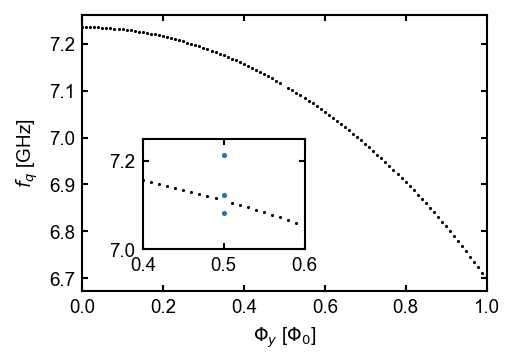

In [34]:
fields = np.linspace(0, 1, 101) # in units of Phi_0
Bc = 2 # in units of Phi_0
Ec = 230e6
Ej0 = 30e9
Em = 20e6
fqs = []
for B in fields:
    Ej = gap_suppression(B, Ej0, Bc)
    if B == 0.5:
        H = H_c(Ec) + H_J_SIS(Ej) + H_M(Em)
        energies = H.eigenenergies()
        fq_transmon = energies[2] - energies[1]
        fq_transmon2 = energies[3] - energies[0]
        fq_normal = energies[2]-energies[0]
    else:
        H = H_c(Ec) + H_J_SIS(Ej)
        fqs.append(fq(H))
fig, ax = plt.subplots()

fqs = np.array(fqs)
ax.plot(fields[fields!=0.5], fqs*1e-9, '.', c='k')

axins = ax.inset_axes([0.15,0.15,0.4,0.4])
axins.plot(fields[fields!=0.5], fqs*1e-9, '.', c='k')
axins.plot(0.5, fq_normal*1e-9, 'C0.', ms=5)
axins.plot(0.5, fq_transmon*1e-9, 'C0.', ms=5)
axins.plot(0.5, fq_transmon2*1e-9, 'C0.', ms=5)
axins.set_xlim(xmin=0.4, xmax=0.6)
axins.set_ylim(ymin=7, ymax=7.25)
ax.set_xlabel(r'$\Phi_y$ [$\Phi_0$]')
ax.set_ylabel(r'$f_q$ [GHz]')
ax.set_xlim(xmin=0, xmax=1)
#plt.scatter(0.5, fq_normal)
fig.savefig('fqVSfields.pdf')

In [52]:
B = 0.5
Ej = gap_suppression(B, Ej0, Bc)
sc = gap_suppression(B, sc_gap, Bc)
data = SIS(phase, Ej=Ej) + SNS(phase, tau_list=tau_list, sc_gap=sc)
freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
Ej_eff = find_Ej(freq, X, size=size)
H = H_c(Ec, ng=n) + H_J(X, size=size, N=N)
fq(H)

8915435004.055912

In [53]:
B = 0.5
Ej = gap_suppression(B, Ej0, Bc)
sc = gap_suppression(B, sc_gap, Bc)
data = SIS(phase, Ej=Ej) + SNS(phase, tau_list=tau_list, sc_gap=sc)
freq, X = fourier_expansion(phase, data, mode='zeroed', norm='forward', plot=False, res=1e-1)
Ej_eff = find_Ej(freq, X, size=size)
H = H_c(Ec, ng=n) + H_J(X, size=size, N=N) + H_M(Em)
energies = H.eigenenergies()
fq_transmon = energies[2] - energies[1]
fq_transmon2 = energies[3] - energies[0]
fq_normal = energies[2]-energies[0]

In [54]:
fq_normal

8918466516.309937

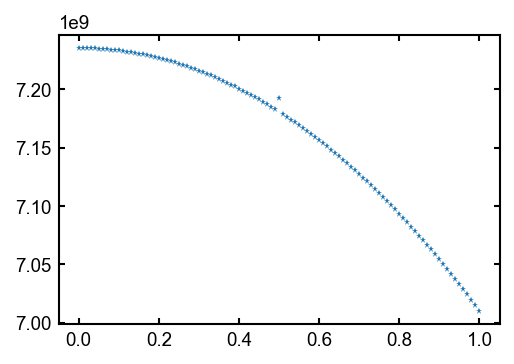

In [13]:
fields = np.linspace(0, 1, 101) # in units of Phi_0
Bc = 3
Ec = 230e6
Ej0 = 30e9
Em = 20e6
fqs = []
for B in fields:
    Ej = gap_suppression(B, Ej0, Bc)
    if B == 0.5:
        H = H_c(Ec) + H_J_SIS(Ej) + H_M(Em)
        energies = H.eigenenergies()
        fq_normal = energies[2]-energies[1]
    else:
        H = H_c(Ec) + H_J_SIS(Ej)
    fqs.append(fq(H))
fig, ax = plt.subplots()
plt.plot(fields, fqs, '*')
#plt.scatter(0.5, fq_normal)

# SNS Transmon

In [ ]:
#Ec = 10e9
Ec = 230e6
Ej = 30e9


ng = np.linspace(-2,2,201)
fqs = []
spectrums = []
for n in ng:
    H = H_c(Ec, ng=n) + H_J_SIS(Ej)
    fqs.append(fq(H))
    spectrums.append(H_spectrum(H))
#plt.plot(ng, fqs)
#spectrums = np.array(spectrums).T
#plt.plot(ng, spectrums)
plot_spectrum(ng, spectrums,cutoff=4)

In [ ]:
def SNS(phi, tau_list, sc_gap=1):
    Ejs = []
    for p in phi:
        Ej = np.sum(np.dot(-sc_gap, np.sqrt(1-tau_list*np.sin(p/2)**2)))
        #print(Ej)
        Ejs.append(Ej)
    return np.array(Ejs)